In [1]:
import numpy as np
import re
from itertools import islice
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const

import os
import sys
from pathlib import Path
from matplotlib import style
from lmfit import Parameters, fit_report, minimize
from lmfit.models import LinearModel
style.use('default')                # needed for vscode dark theme to see the axis

In [2]:
save_as_pgf = 0
save_as_pdf = 1

if save_as_pgf == 1:
    #mpl.use("pgf")                        
    mpl.rc('text', usetex=True)           # needed for latex
    mpl.rc('pgf', texsystem='pdflatex')   # change this if using xetex or luatex
    mpl.rc('pgf', rcfonts=False)          # don't setup fonts from rc parameters
    mpl.rc('pgf', preamble="\n".join([    # load additional packages
           r"\usepackage[utf8x]{inputenc}",
           r"\usepackage[T1]{fontenc}",
           r"\usepackage{amsmath,amsfonts,amsthm,amssymb,amstext}"]))
    mpl.rc('font', size=8)                # default font size
    mpl.rc('font', family='serif')          # use serif fonts
    #mpl.rc('font', family='sans-serif')   # use sans-serif fonts
    mpl.rc('font', serif='Latin Modern')  # use latex default serif font
    mpl.rc('axes', titlesize=10)           # fontsize of the axes title
    mpl.rc('axes', titlepad=2)            # pad between axis and title
    mpl.rc('axes', labelsize=10)           # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=8)          # fontsize of the tick labels
    mpl.rc('ytick', labelsize=8)          # fontsize of the tick labels
    mpl.rc('legend', fontsize=8)          # legend fontsize
    mpl.rc('figure', titlesize=10)         # fontsize of the figure title
    mpl.rc('lines', markersize=2)         # default line markersize
    mpl.rc('lines', marker="")            # default line marker
    mpl.rc('grid', alpha=0.4)             # transparency of the grid
    mpl.rc('grid', color="gray")          # color of the grid
    mpl.rc('grid', linewidth=0.5)         # linewidth of the grid
    mpl.rcParams['figure.constrained_layout.use'] = True # use constrained_layout
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b", "g", "orange", "purple"]) #matplotlib colororder-default ändern
    lw = 1.0                              # linewidth of the lines

    # width and height of tex document in inches
    # For Katrins Bachelor thesis
    # in Latex:
    # \usepackage{layouts}
    # textwidth in inches: \printinunitsof{in}\prntlen{\textwidth}
    
    fig_width = 6.202
    fig_height = fig_width * 0.6
    
elif save_as_pdf == 1:
    normal = 9                              # fontsize of the text
    mpl.rc('font', size=normal+2)             # default font size
    mpl.rc('font', family='serif')          # use serif fonts
    mpl.rc('axes', titlesize=normal)        # fontsize of the axes title
    mpl.rc('axes', titlepad=5)              # pad between axis and title
    mpl.rc('axes', labelpad=7)              # pad between axis and label
    mpl.rc('axes', labelsize=normal+2)      # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=normal)       # fontsize of the tick labels
    mpl.rc('ytick', labelsize=normal)       # fontsize of the tick labels
    mpl.rc('legend', fontsize=normal)       # legend fontsize
    mpl.rc('figure', titlesize=normal+4)    # fontsize of the figure title
    mpl.rc('lines', markersize=12)          # default line markersize
    mpl.rc('lines', marker="")              # default line marker
    mpl.rc('grid', alpha=0.4)               # transparency of the grid              
    mpl.rc('grid', color="gray")            # color of the grid
    mpl.rc('grid', linewidth=0.5)           # linewidth of the grid
    mpl.rcParams["xtick.major.size"] = 8    # major tick size in points
    mpl.rcParams["ytick.major.size"] = 8    # major tick size in points
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b", "g", "orange", "purple"]) #matplotlib colororder-default ändern
    
    lw = 2
    ms_4 = 4
    ms_8 = 8

    # height and width for nice print in jupyter notebook
    fig_width = 8
    fig_height = 5
    
else:
    mpl.rc('font', size=16)                 # controls default text sizes
    mpl.rc('axes', titlesize=16)            # fontsize of the axes title
    mpl.rc('axes', labelsize=18)            # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=16)           # fontsize of the tick labels
    mpl.rc('ytick', labelsize=16)           # fontsize of the tick labels
    mpl.rc('legend', fontsize=18)           # legend fontsize
    mpl.rc('figure', titlesize=18)          # fontsize of the figure title
    mpl.rc('grid', alpha=0.4)
    mpl.rc('lines', markersize=10)    
    
    

def save_plot_as_pgf(fig, path):
  if save_as_pgf == 1:
    fig.savefig(path, format="pgf")

def save_plot_as_pdf(fig, path):
  if save_as_pdf == 1:
    fig.savefig(path, format="pdf", bbox_inches='tight')


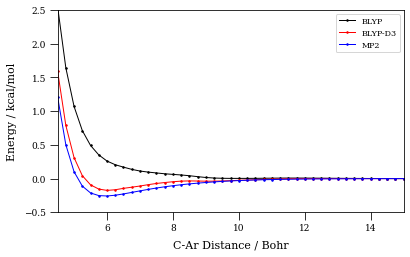

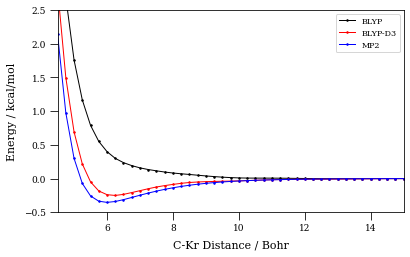

In [3]:
# Load data
Ar_blyp = np.loadtxt('Ar_blyp.dat', usecols=(1))
Ar_blyp_D3 = np.loadtxt('Ar_blyp_D3.dat', usecols=(1))
Ar_MP2 = np.loadtxt('Ar_MP2.dat', usecols=(1))
Kr_blyp = np.loadtxt('Kr_blyp.dat', usecols=(1))
Kr_blyp_D3 = np.loadtxt('Kr_blyp_D3.dat', usecols=(1))
Kr_MP2 = np.loadtxt('Kr_MP2.dat', usecols=(1))
x = np.loadtxt('Kr_MP2.dat', usecols=(0))

# define figure
fig_width = 6.202
fig_height = fig_width * 0.6
fig = plt.figure(figsize=(fig_width, fig_height))
spec = fig.add_gridspec(ncols=1, nrows=1, height_ratios=[1])
fig2 = plt.figure(figsize=(fig_width, fig_height))

# define subplots
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig2.add_subplot(spec[0, 0])

# plot data; normed to E at 15 as 0 and in kcal/mol
lw = 1.0 
#Ar
ax1.plot(x, (Ar_blyp+568.0549296344)*627.5, label='BLYP', linewidth=lw, marker='.', markersize=3)
ax1.plot(x, (Ar_blyp_D3+568.0573273673)*627.5, label='BLYP-D3', linewidth=lw, marker='.', markersize=3)
ax1.plot(x, (Ar_MP2+567.7151205538)*627.5, label='MP2', linewidth=lw, marker='.', markersize=3)
#Kr
ax2.plot(x, (Kr_blyp+2794.343628490)*627.5, label='BLYP', linewidth=lw, marker='.', markersize=3)
ax2.plot(x, (Kr_blyp_D3+2794.346028618)*627.5, label='BLYP-D3', linewidth=lw, marker='.', markersize=3)
ax2.plot(x, (Kr_MP2+2793.0784218860)*627.5, label='MP2', linewidth=lw, marker='.', markersize=3)


# set labels
ax1.set_xlabel('C-Ar Distance / Bohr')
ax1.set_ylabel('Energy / kcal/mol')
ax2.set_xlabel('C-Kr Distance / Bohr')
ax2.set_ylabel('Energy / kcal/mol')


# set limits
ax1.set_xlim(4.5, 15.0)
ax1.set_ylim(-0.5, 2.5)
ax2.set_xlim(4.5, 15.0)
ax2.set_ylim(-0.5, 2.5)

# set legend and title
ax1.legend(loc='best', fancybox=True, fontsize=8)
ax2.legend(loc='best', fancybox=True, fontsize=8)

# show plot
plt.show()

# save plot
save_plot_as_pdf(fig, 'Ar.pdf')
save_plot_as_pdf(fig2, 'Kr.pdf')